# 04 - LDA Topic Modeling

This notebook trains the LDA (Latent Dirichlet Allocation) topic model.

## Steps
- Load processed corpus
- Create dictionary and corpus
- Find optimal number of topics (coherence-based)
- Train final model
- Evaluate and save model

In [1]:
# Import required libraries
import sys
import pickle
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Add project root to path
project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

from src.config import get_settings, ensure_directories
from src.lda_model import LDATopicModel, find_optimal_topics

In [2]:
# Load settings
settings = get_settings()
ensure_directories(settings)

# Load processed corpus
corpus_path = settings.processed_data_dir / settings.processed_corpus_file
print(f"Loading processed corpus from: {corpus_path}")

with open(corpus_path, 'rb') as f:
    corpus_data = pickle.load(f)

processed_docs = corpus_data['documents']
df = corpus_data['dataframe']

print(f"Loaded {len(processed_docs):,} documents")

Loading processed corpus from: C:\Users\alifn\PycharmProjects\topic-modeling-utama\data\processed\processed_corpus.pkl
Loaded 11,979 documents


## 1. Explore Corpus Statistics

In [3]:
# Corpus statistics
all_tokens = [t for doc in processed_docs for t in doc]
unique_tokens = set(all_tokens)

print("Corpus Statistics:")
print("-" * 40)
print(f"Documents: {len(processed_docs):,}")
print(f"Total tokens: {len(all_tokens):,}")
print(f"Unique tokens: {len(unique_tokens):,}")
print(f"Avg tokens/doc: {len(all_tokens)/len(processed_docs):.1f}")

Corpus Statistics:
----------------------------------------
Documents: 11,979
Total tokens: 861,113
Unique tokens: 35,643
Avg tokens/doc: 71.9


## 2. Find Optimal Number of Topics

We'll train models with different numbers of topics and evaluate using coherence score.

In [4]:
# Configuration for topic search
TOPIC_RANGE = range(4, 15, 2)

# Set to True to run the search (can take a long time)
RUN_TOPIC_SEARCH = True

# If you already know the optimal number of topics, set it here
FIXED_NUM_TOPICS = None if settings.lda_num_topics == 0 else settings.lda_num_topics

print(f"Topic range to test: {list(TOPIC_RANGE)}")

Topic range to test: [4, 6, 8, 10, 12, 14]


In [5]:
if RUN_TOPIC_SEARCH and FIXED_NUM_TOPICS is None:
    print("Finding optimal number of topics...")
    print("This may take a while...")
    print("-" * 50)
    
    optimal_topics, search_results = find_optimal_topics(
        processed_docs,
        topic_range=TOPIC_RANGE,
        settings=settings,
        show_progress=True,
    )
    
    print(f"\n✅ Optimal number of topics: {optimal_topics}")
else:
    optimal_topics = FIXED_NUM_TOPICS or settings.lda_num_topics
    search_results = None
    print(f"Using fixed number of topics: {optimal_topics}")

Finding optimal number of topics...
This may take a while...
--------------------------------------------------


Testing topic counts:   0%|          | 0/6 [00:00<?, ?it/s]INFO:src.lda_model:Creating dictionary...
INFO:gensim.corpora.dictionary:adding document #0 to Dictionary<0 unique tokens: []>
INFO:gensim.corpora.dictionary:adding document #10000 to Dictionary<32397 unique tokens: ['arta', 'budaya', 'determinasi', 'dianalisis', 'diteliti']...>
INFO:gensim.corpora.dictionary:built Dictionary<35643 unique tokens: ['arta', 'budaya', 'determinasi', 'dianalisis', 'diteliti']...> from 11979 documents (total 861113 corpus positions)
INFO:gensim.utils:Dictionary lifecycle event {'msg': "built Dictionary<35643 unique tokens: ['arta', 'budaya', 'determinasi', 'dianalisis', 'diteliti']...> from 11979 documents (total 861113 corpus positions)", 'datetime': '2025-12-13T16:41:16.077514', 'gensim': '4.4.0', 'python': '3.12.10 (tags/v3.12.10:0cc8128, Apr  8 2025, 12:21:36) [MSC v.1943 64 bit (AMD64)]', 'platform': 'Windows-11-10.0.26200-SP0', 'event': 'created'}
INFO:gensim.corpora.dictionary:discarding 3140


✅ Optimal number of topics: 12


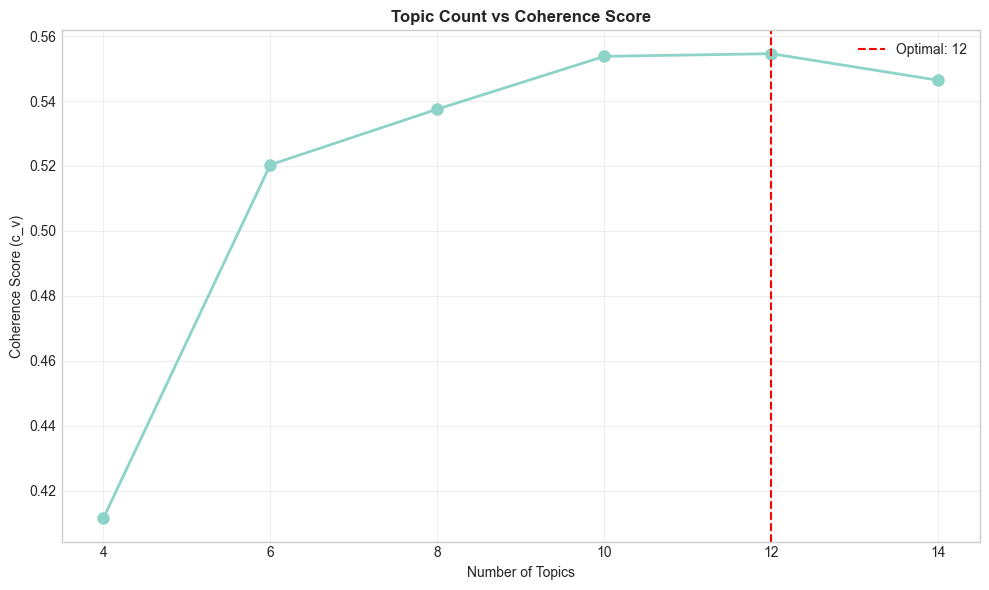

Saved search results to: C:\Users\alifn\PycharmProjects\topic-modeling-utama\outputs\topic_coherence_results.csv


In [6]:
# Plot coherence scores
if search_results:
    fig, ax = plt.subplots(figsize=(10, 6))
    
    topics = [r['num_topics'] for r in search_results]
    coherences = [r['coherence'] for r in search_results]
    
    ax.plot(topics, coherences, 'o-', markersize=8, linewidth=2)
    ax.axvline(optimal_topics, color='red', linestyle='--', 
               label=f'Optimal: {optimal_topics}')
    
    ax.set_xlabel('Number of Topics')
    ax.set_ylabel('Coherence Score (c_v)')
    ax.set_title('Topic Count vs Coherence Score', fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

    fig.savefig(f"{settings.outputs_dir}/coherence_score.png", dpi=300, bbox_inches='tight')
    
    plt.tight_layout()
    plt.show()
    
    # Save results
    results_df = pd.DataFrame(search_results)
    results_path = settings.outputs_dir / 'topic_coherence_results.csv'
    results_df.to_csv(results_path, index=False)
    print(f"Saved search results to: {results_path}")

## 3. Train Final Model

In [7]:
# Model configuration
NUM_TOPICS = optimal_topics
PASSES = settings.lda_passes
ITERATIONS = settings.lda_iterations
WORKERS = settings.lda_workers

print(f"Training final model with configuration:")
print(f"  Topics: {NUM_TOPICS}")
print(f"  Passes: {PASSES}")
print(f"  Iterations: {ITERATIONS}")
print(f"  Workers: {WORKERS}")

Training final model with configuration:
  Topics: 12
  Passes: 20
  Iterations: 400
  Workers: 6


In [8]:
# Train model
print("\nTraining LDA model...")
print("-" * 50)

model = LDATopicModel(settings)
model.train(
    processed_docs,
    num_topics=NUM_TOPICS,
    passes=PASSES,
    iterations=ITERATIONS,
    workers=WORKERS,
    show_progress=True,
)

print("\n✅ Training complete!")

INFO:src.lda_model:Creating dictionary...
INFO:gensim.corpora.dictionary:adding document #0 to Dictionary<0 unique tokens: []>



Training LDA model...
--------------------------------------------------


INFO:gensim.corpora.dictionary:adding document #10000 to Dictionary<32397 unique tokens: ['arta', 'budaya', 'determinasi', 'dianalisis', 'diteliti']...>
INFO:gensim.corpora.dictionary:built Dictionary<35643 unique tokens: ['arta', 'budaya', 'determinasi', 'dianalisis', 'diteliti']...> from 11979 documents (total 861113 corpus positions)
INFO:gensim.utils:Dictionary lifecycle event {'msg': "built Dictionary<35643 unique tokens: ['arta', 'budaya', 'determinasi', 'dianalisis', 'diteliti']...> from 11979 documents (total 861113 corpus positions)", 'datetime': '2025-12-13T16:44:43.555095', 'gensim': '4.4.0', 'python': '3.12.10 (tags/v3.12.10:0cc8128, Apr  8 2025, 12:21:36) [MSC v.1943 64 bit (AMD64)]', 'platform': 'Windows-11-10.0.26200-SP0', 'event': 'created'}
INFO:gensim.corpora.dictionary:discarding 31402 tokens: [('arta', 6), ('dwitunggal', 2), ('enginering', 1), ('gani', 2), ('menginterprestasi', 7), ('mengklarifikasi', 10), ('agoestiana', 4), ('agronesia_divisi', 10), ('andri', 3), (


✅ Training complete!


In [9]:
# Display model metadata
if model.metadata:
    meta = model.metadata
    print("\nModel Metadata:")
    print("=" * 50)
    print(f"Number of topics:    {meta.num_topics}")
    print(f"Number of documents: {meta.num_documents:,}")
    print(f"Vocabulary size:     {meta.vocabulary_size:,}")
    print(f"Coherence score:     {meta.coherence_score:.4f}")
    print(f"Training time:       {meta.training_time_seconds:.1f}s")


Model Metadata:
Number of topics:    12
Number of documents: 11,979
Vocabulary size:     4,241
Coherence score:     0.5546
Training time:       25.0s


## 4. Explore Topics

In [10]:
# Display all topics
topics = model.get_topics(num_words=15)

print(f"\n{len(topics)} Topics Discovered:")
print("=" * 70)

for topic in topics:
    words = ', '.join(topic.top_words[:10])
    print(f"\nTopic {topic.topic_id}:")
    print(f"  {words}")


12 Topics Discovered:

Topic 0:
  penjualan, biaya, produksi, produk, pengendalian, persediaan, bahan_baku, barang, sistem, aktivitas

Topic 1:
  karyawan, kinerja_karyawan, kinerja, disiplin_kerja, pegawai, motivasi, motivasi_kerja, kerja, kompensasi, lingkungan_kerja

Topic 2:
  modal_kerja, pendapatan_asli, kerja, hotel, koperasi, piutang, pemerintah, lapangan, belanja, program

Topic 3:
  sistem, aplikasi, informasi, media, perancangan, penggunaan, jaringan, teknologi, layanan, umkm

Topic 4:
  profitabilitas, bursa_efek, independen, ukuran, roa, kepatuhan_wajib, sampling, purposive_sampling, non_performing, kebijakan_dividen

Topic 5:
  pajak, wajib_pajak, penerimaan_pajak, kas, pendapatan, kepatuhan_wajib, anggaran, badan, negara, kantor_pelayanan

Topic 6:
  karyawan, proyek, karya, film, gaya_kepemimpinan, produktivitas_kerja, fungsi, aktiva, strategi, promosi_jabatan

Topic 7:
  keuangan, kinerja, bank, informasi, kondisi, lingkungan, pemerintah, investasi, syariah, dana

Top

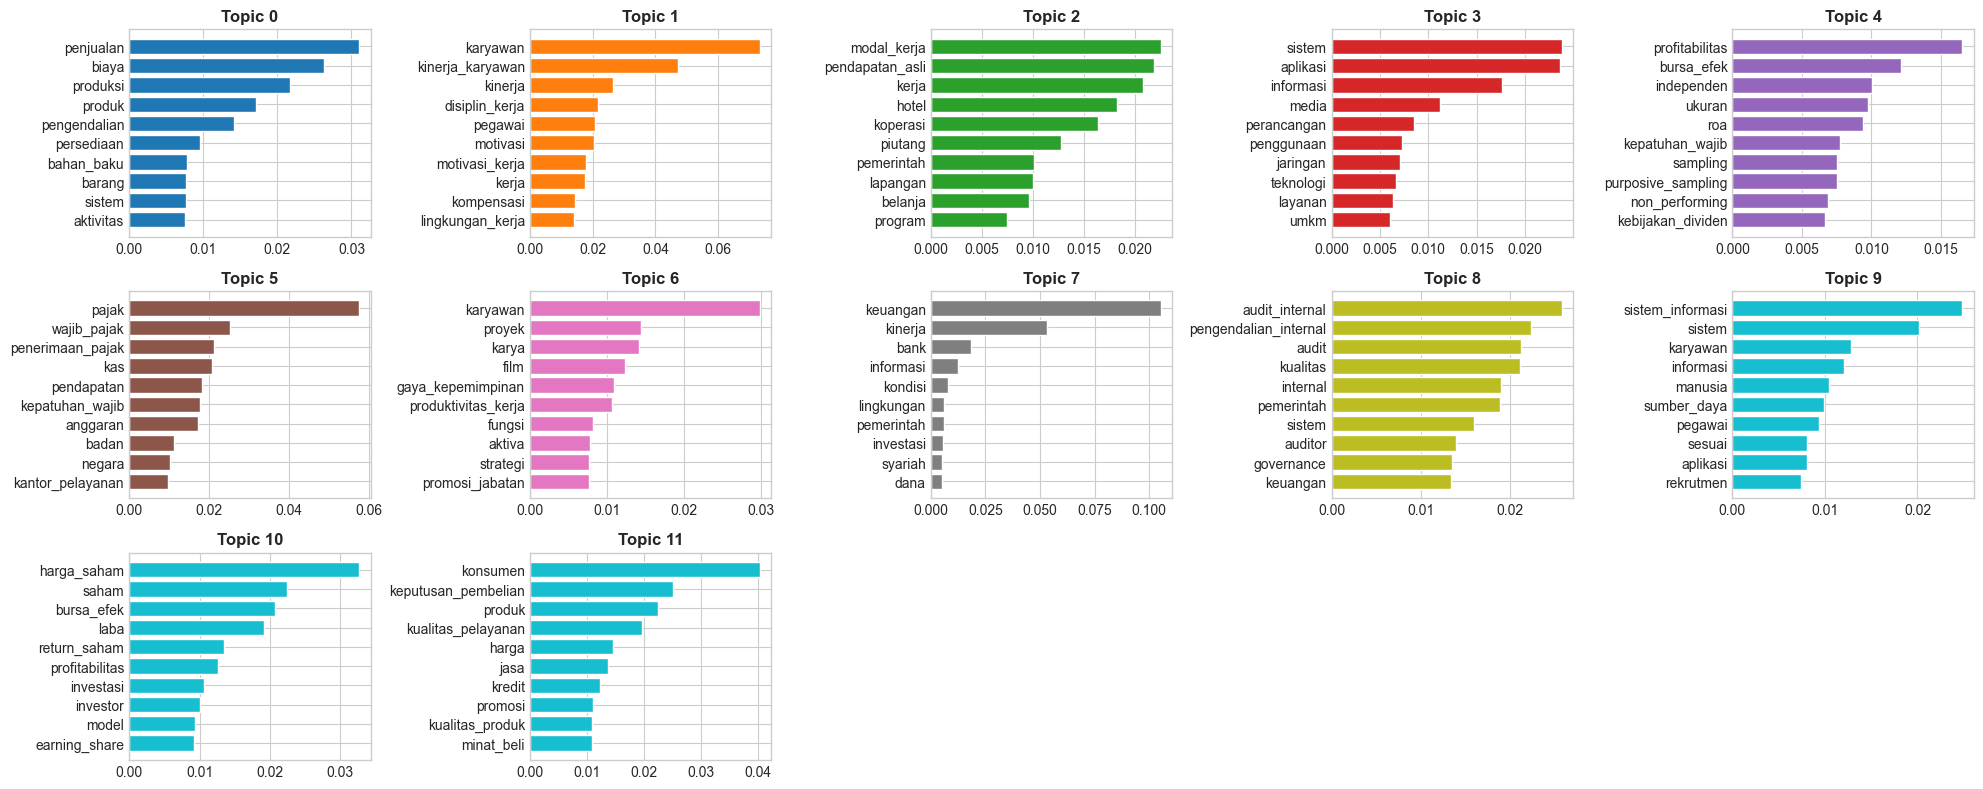

In [11]:
# Visualize topic words
fig, axes = plt.subplots(3, min(5, NUM_TOPICS//2 + 1), figsize=(20, 8))
axes = axes.flatten()

for i, topic in enumerate(topics[:40]):
    if i >= len(axes):
        break
    
    words = [w for w, _ in topic.words[:10]]
    weights = [w for _, w in topic.words[:10]]
    
    ax = axes[i]
    ax.barh(range(len(words)), weights, color=plt.cm.tab10(i))
    ax.set_yticks(range(len(words)))
    ax.set_yticklabels(words)
    ax.invert_yaxis()
    ax.set_title(f'Topic {topic.topic_id}', fontweight='bold')

# Hide unused subplots
for i in range(len(topics), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

fig.savefig(f"{settings.outputs_dir}/topic_words.png", dpi=300, bbox_inches='tight')

## 5. Document-Topic Distribution

In [12]:
# Get topic distribution for all documents
print("Computing document-topic distributions...")
topic_matrix = model.get_document_topic_matrix(processed_docs, show_progress=True)

print(f"\nMatrix shape: {topic_matrix.shape}")

Computing document-topic distributions...


Computing topic distributions: 100%|██████████| 11979/11979 [00:02<00:00, 4232.28it/s]


Matrix shape: (11979, 12)


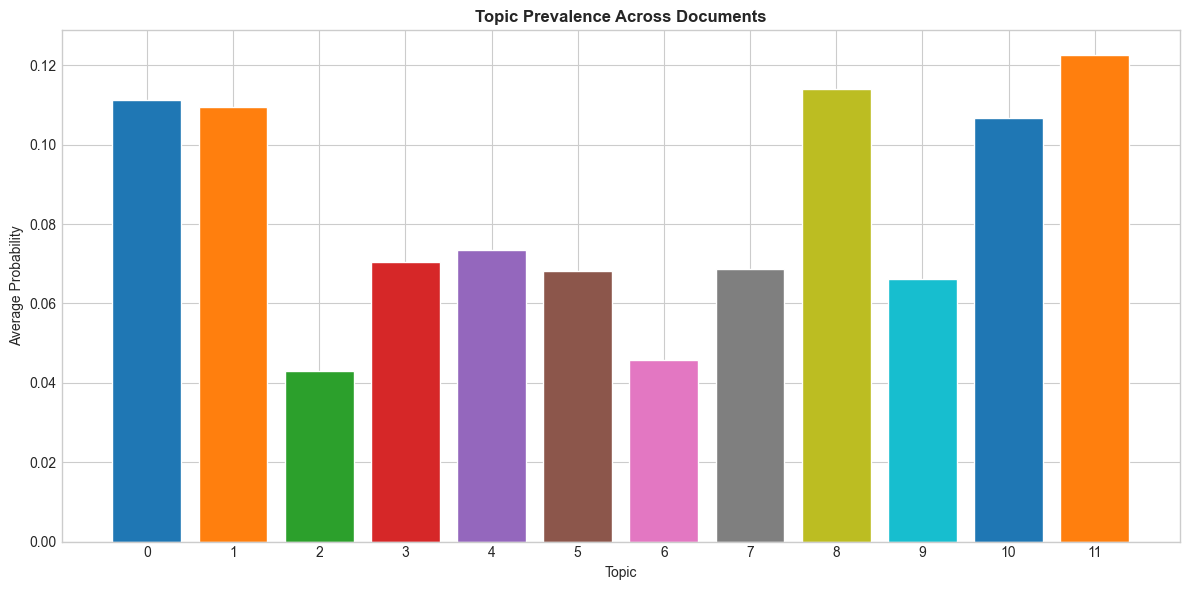

In [13]:
# Topic prevalence
topic_prevalence = topic_matrix.mean(axis=0)

fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(range(NUM_TOPICS), topic_prevalence, color=plt.cm.tab10.colors[:NUM_TOPICS])
ax.set_xlabel('Topic')
ax.set_ylabel('Average Probability')
ax.set_title('Topic Prevalence Across Documents', fontweight='bold')
ax.set_xticks(range(NUM_TOPICS))

plt.tight_layout()
plt.show()

In [14]:
# Sample document topic assignments
print("\nSample Document-Topic Assignments:")
print("-" * 60)

for i in range(min(5, len(df))):
    dominant_topic = np.argmax(topic_matrix[i])
    prob = topic_matrix[i, dominant_topic]
    title = df.iloc[i]['title'][:60]
    print(f"Doc {i}: Topic {dominant_topic} ({prob:.2f}) - {title}...")


Sample Document-Topic Assignments:
------------------------------------------------------------
Doc 0: Topic 1 (0.58) - PENGARUH BUDAYA KESELAMATAN DAN KESEHATAN KERJA (K3) DAN PRO...
Doc 1: Topic 1 (0.55) - Pengaruh Kompensasi terhadap Motivasi Kerja Karyawan pada PT...
Doc 2: Topic 9 (0.75) - PERANAN SISTEM INFORMASI AKUNTANSI DALAM MENUNJANG EFEKTIFIT...
Doc 3: Topic 1 (0.81) - PENGARUH USIA DAN MASA KERJA TERHADAP PRODUKTIVITAS PEGAWAI ...
Doc 4: Topic 8 (0.98) - PENGARUH SISTEM PENGENDALIAN INTERNAL PEMERINTAH TERHADAP KU...


## 6. Save Model

In [15]:
# Save model and artifacts
model_dir = model.save()

print(f"\n✅ Model saved to: {model_dir}")

INFO:gensim.utils:LdaState lifecycle event {'fname_or_handle': 'C:\\Users\\alifn\\PycharmProjects\\topic-modeling-utama\\models\\lda_model.model.state', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2025-12-13T16:45:22.028789', 'gensim': '4.4.0', 'python': '3.12.10 (tags/v3.12.10:0cc8128, Apr  8 2025, 12:21:36) [MSC v.1943 64 bit (AMD64)]', 'platform': 'Windows-11-10.0.26200-SP0', 'event': 'saving'}
INFO:gensim.utils:saved C:\Users\alifn\PycharmProjects\topic-modeling-utama\models\lda_model.model.state
INFO:gensim.utils:LdaMulticore lifecycle event {'fname_or_handle': 'C:\\Users\\alifn\\PycharmProjects\\topic-modeling-utama\\models\\lda_model.model', 'separately': "['expElogbeta', 'sstats']", 'sep_limit': 10485760, 'ignore': ['id2word', 'dispatcher', 'state'], 'datetime': '2025-12-13T16:45:22.032463', 'gensim': '4.4.0', 'python': '3.12.10 (tags/v3.12.10:0cc8128, Apr  8 2025, 12:21:36) [MSC v.1943 64 bit (AMD64)]', 'platform': 'Windows-11-10.0.26200-SP


✅ Model saved to: C:\Users\alifn\PycharmProjects\topic-modeling-utama\models


In [16]:
# Also save topic-document matrix for dashboard
matrix_path = settings.processed_data_dir / settings.topic_document_matrix_file

# Create DataFrame with topic columns
df_topics = df.copy()
for i in range(NUM_TOPICS):
    df_topics[f'topic_{i}'] = topic_matrix[:, i]

df_topics['dominant_topic'] = np.argmax(topic_matrix, axis=1)
df_topics['dominant_prob'] = np.max(topic_matrix, axis=1)

# Remove tokens column (too large for CSV)
if 'tokens' in df_topics.columns:
    df_topics = df_topics.drop(columns=['tokens'])

df_topics.to_csv(matrix_path, index=False)
print(f"✅ Topic-document matrix saved to: {matrix_path}")

✅ Topic-document matrix saved to: C:\Users\alifn\PycharmProjects\topic-modeling-utama\data\processed\topic_document_matrix.csv


## Summary

In [17]:
print("\n" + "=" * 60)
print("LDA MODELING COMPLETE")
print("=" * 60)
print(f"\n📊 Topics: {NUM_TOPICS}")
print(f"📈 Coherence: {model.metadata.coherence_score:.4f}")
print(f"📚 Documents: {len(processed_docs):,}")
print(f"📝 Vocabulary: {model.metadata.vocabulary_size:,}")

print(f"\n📁 Model artifacts saved to: {model_dir}")

print(f"\n👉 Next: Run 05_analysis_visualization.ipynb for detailed analysis")
print(f"   Then: Launch the Streamlit dashboard with 'streamlit run dashboard/app.py'")


LDA MODELING COMPLETE

📊 Topics: 12
📈 Coherence: 0.5546
📚 Documents: 11,979
📝 Vocabulary: 4,241

📁 Model artifacts saved to: C:\Users\alifn\PycharmProjects\topic-modeling-utama\models

👉 Next: Run 05_analysis_visualization.ipynb for detailed analysis
   Then: Launch the Streamlit dashboard with 'streamlit run dashboard/app.py'
